In [1]:
import pandas as pd
import numpy as np
import os
import random
import math
import datetime
import matplotlib.pyplot as plt


In [ ]:
"""
dataset은 102개의 컬럼으로 구성됨.
첫번째 컬럼은 article을 1~10으로 나타냄
두번째 컬럼은 real-word 데이터인데 첫번째 컬럼 article(1~10)을 user에게 추천해줬을때
click시 1, non-click은 0. 0/1로 나타냄

나머지 100개의 컬럼은 feature vector를 나타냄

dataset2는 101개의 컬럼으로 구성됨. 
첫번째 컬럼은 article number로 1~10으로 나타냄
그리고 첫번째 컬럼은 user에게 보여주고 user는 그것을 click

"""

In [2]:
DATA_FILE_1 = "C:/Users/seunghwa/Desktop/dataset.txt"
DATA_FILE_2 = "C:/Users/seunghwa/Desktop/dataset_2.txt"

In [3]:
def plot_cumulative_take_rate(cumulative_take_rates):
    times = [x+2 for x in range(9999)]
    y = []
    for t in times:
        y.append(cumulative_take_rates[t])
    x = np.asarray(times)
    y = np.asarray(y)
    plt.plot(x, y)
    max_index = np.argmax(y)
    max_ctr = y[max_index]
    max_alpha = x[max_index]
    plt.plot(max_alpha, max_ctr, 'r*')
    plt.show()

In [4]:
def find_optimal_alpha_1(time):
    return 1/np.sqrt(time)

In [21]:

def LinUCB_modified(data_file, alpha=0.0, plot_or_not=True):
    articles = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    T = [x+2 for x in range(9999)]
    m = 10 # number of articles
    d = 100 # number of features
    total_payoff = 0.0
    time = 1 # to plot time series
    ctrs = {} # dict of time vs cumulative take rates
    ctr_num = 0.0 # initialising the CTR numerator
    ctr_den = 1.0 # initialising the CTR denominator
    matches = 0.0 # to record the number of matches between predicted arm and actual arm
    first = True
    with open(data_file, 'r') as data_file:
        lines = data_file.readlines()
        for line in lines:
            features = line.split(' ')
            real_article_chosen = features[0]
            reward = features[1]
            features = features[2:102]
            if first:
                first = False
                A = np.zeros((m, d, d))
                for a in range(10):
                    A[a] = np.eye(d)
                b = np.zeros((m, d, 1))
            ratings = np.zeros(m)
            for a in range(10):
                A_inv = np.linalg.inv(A[a])
                theta_a = A_inv.dot(b[a])
                features = np.asarray(features).astype(int)
                features = np.reshape(features, (100, 1))
                # uncomment the below when you want alpha based on time (1/sqrt(T))
                alpha = find_optimal_alpha_1(time) 
                ratings[a] = np.matmul(theta_a.T, features) + alpha * np.sqrt(np.matmul(np.matmul(features.T, A_inv), features))
            chosen_article = articles[np.random.choice(np.flatnonzero(ratings == ratings.max()))]
            if int(chosen_article) == int(real_article_chosen):
                # print("match at:",time)
                matches += 1.0
                total_payoff += float(reward)
                A[int(real_article_chosen)-1] += features.dot(features.T)
                b[int(real_article_chosen)-1] = b[int(real_article_chosen)-1] + int(reward)* features
                ctr_num += int(reward)
                # to account for the 1.0 initialization of ctr_den instead of 0.0
                if ctr_den != 0.0:
                    ctr_den += 1
                ctrs[time] = ctr_num/(1.0*ctr_den)
            else:
                ctrs[time] = ctr_num/(1.0*ctr_den)
            time += 1
    if plot_or_not:
        plot_cumulative_take_rate(ctrs)
    total_payoff /= matches
    return (ctrs[10000], total_payoff)

In [22]:
def call_LinUCB(data_file, number, alpha=0.0):
    sum_ctr = 0.0
    sum_payoff = 0.0
    for i in range(number):
        ctr, payoff = LinUCB_modified(data_file)
        sum_ctr += ctr
        sum_payoff += payoff
    return sum_ctr/number, sum_payoff/number

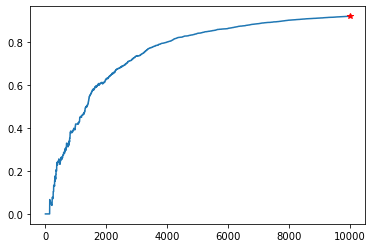

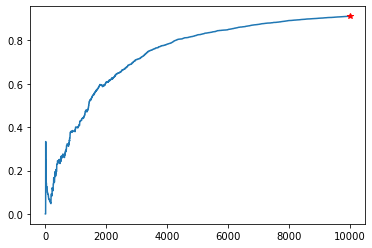

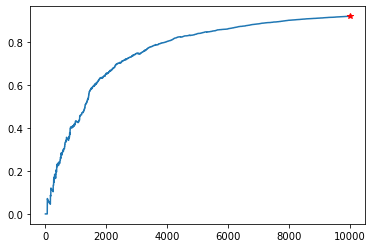

Cumulative Take rate: 0.9165806133377895, Total Payoff: 0.9174576343867611
Wall time: 7min 26s


In [23]:
%%time
(ctr, payoff) = call_LinUCB(DATA_FILE_1, 3)
print("Cumulative Take rate: " + str(ctr) + ", Total Payoff: " + str(payoff))

In [8]:
def find_optimal_alpha_2():
    values = np.arange(0.0001, 0.02, 0.001)
    ctrs = []
    for a in values:
        ctr, payoff = LinUCB_modified(DATA_FILE_1, alpha=a, plot_or_not=False)
        ctrs.append(ctr)
        print(str(a) + "---" + str(ctr))
    x = np.asarray(values)
    y = np.asarray(ctrs)
    plt.plot(x, y)
    max_index = np.argmax(y)
    max_ctr = y[max_index]
    max_alpha = x[max_index]
    print("alpha with maximum ctr: " + str(max_alpha))
    plt.plot(max_alpha, max_ctr, 'r*')
    plt.show()

0.0001---0.8912621359223301
0.0011---0.9415148609779482
0.0021---0.9447619047619048
0.0031---0.9456106870229007
0.0041---0.9465648854961832
0.0051---0.944234404536862
0.0061---0.936007640878701
0.0071---0.9401140684410646
0.0081---0.9369024856596558
0.0091---0.9301435406698565
0.0101---0.9324452901998097
0.011099999999999999---0.9314009661835749
0.0121---0.9233716475095786
0.0131---0.9191820837390458
0.0141---0.9189971070395371
0.015099999999999999---0.9172346640701071
0.0161---0.9176245210727969
0.0171---0.917953667953668
0.0181---0.9145299145299145
0.0191---0.9136276391554703
alpha with maximum ctr: 0.0041


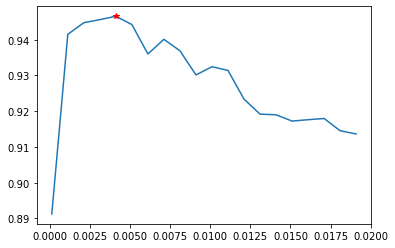

In [9]:
find_optimal_alpha_2()

In [10]:
def find_optimal_alpha_3():
    deltas = np.arange(1, 2, 0.1)
    ctrs = []
    for d in deltas:
        alpha = 1.0 + np.sqrt(math.log(2.0/d)/2)
        ctr, payoff = LinUCB_modified(DATA_FILE_1, alpha, False)
        ctrs.append(ctr)
        print(str(alpha) + "---" + str(ctr))
    x = np.asarray(deltas)
    y = np.asarray(ctrs)
    plt.plot(x, y)
    plt.show()

1.5887050112577374---0.1543026706231454
1.5467343965563263---0.1491317671092952
1.5053838262973946---0.1544477028347996
1.4641028528744755---0.15113871635610765
1.4223002154502955---0.15332690453230471
1.379263808220466---0.15282051282051282
1.3340236154182885---0.15173116089613034
1.285060458059141---0.16972034715525555
1.22952180251321---0.1748792270531401
1.1601457061359282---0.17311411992263057


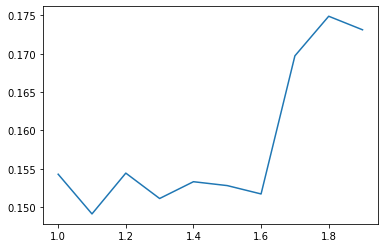

In [11]:

find_optimal_alpha_3()

In [12]:
def LinUCB(data_file, alpha=0.0, plot_or_not=True):
    articles = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    T = [x+2 for x in range(9999)]
    m = 10 # number of articles
    d = 100 # number of features
    time = 1 # to plot time series
    matches = 0.0 # to record the number of matches between predicted arm and actual arm
    first = True
    with open(data_file, 'r') as data_file:
        lines = data_file.readlines()
        for line in lines:
            features = line.split(' ')
            real_article_chosen = features[0]
            features = features[1:101]
            if first:
                first = False
                A = np.zeros((m, d, d))
                for a in range(10):
                    A[a] = np.eye(d)
                b = np.zeros((m, d, 1))
            ratings = np.zeros(m)
            for a in range(10):
                A_inv = np.linalg.inv(A[a])
                theta_a = A_inv.dot(b[a])
                features = np.asarray(features).astype(int)
                features = np.reshape(features, (100, 1))
                # uncomment the below when you want alpha based on time (1/sqrt(T))
                #alpha = find_optimal_alpha_1(time) 
                ratings[a] = np.matmul(theta_a.T, features) + alpha * np.sqrt(np.matmul(np.matmul(features.T, A_inv), features))
            chosen_article = articles[np.random.choice(np.flatnonzero(ratings == ratings.max()))]
            if int(chosen_article) == int(real_article_chosen):
                #print("match at: " + str(time))
                reward = 1.0   
                matches += 1.0
            else:
                reward = 0.0
            A[int(chosen_article)-1] += features.dot(features.T)
            b[int(chosen_article)-1] = b[int(chosen_article)-1] + int(reward)* features
            time += 1
    return (matches)

In [16]:

# %%time
matches = LinUCB(DATA_FILE_2, alpha=0.0001)
print("Overall number of matches: " + str(matches))

Overall number of matches: 9868.0
